### Import dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

print(tf.__version__)

1.15.2


In [ ]:
% pip install wandb

In [ ]:
% pip install librosa==0.8.0

In [ ]:
import numpy as np
import tensorflow as tf
from os.path import isfile, exists
import random
import librosa
from skimage.transform import resize
import utils
from process_data import return_mel_spec_single_channel
from code_HGN_senEM_test import define_model, session_run
prev_img_idx = 0 # Needed for saving image

print('Load needed things!')

Load needed things!


### Load preprocessed data

In [ ]:
relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v1.2_single_channel/preprocessed4HGN_speech2pickup.npz'

data = np.load(relative_data_directory_path)

img_idx = data['img_idx']
sen_len = data['seq_len']
speech_inputs = data['inputs']
pos_outputs = data['outputs']
sentence = data['sentence']

print('End loading MetaData')

num_data = img_idx.shape[0]

End loading MetaData


### Define Model : Run this cell only once per one kernel 

In [ ]:
n_mels = 40
time_steps = 303
dropout_rate = 0.1
encoder_args = {'num_stacks': 3, 'num_channels':[n_mels for i in range(6)], 'kernel_size':3,
                'dropout_rate': dropout_rate, 'activation': 'leaky-relu', 'return_type': 'end'}
input_shapes = (None, n_mels, time_steps)
seed = 1
training_state = True  # Even testing, training set should be set 'True' due to written code mistake

result_heatmap, ph_image, ph_speech, ph_dropout = define_model(n_mels = 40,
                                                               time_steps = 303,
                                                               num_hg_Depth = 4,
                                                               dim_hg_feat = 256,
                                                               encoder_args = encoder_args,
                                                               input_shapes = input_shapes,
                                                               seed = seed,
                                                               training_state = training_state)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.



### Get test image index. Refer the printed result when you check the result from the test data

In [ ]:
idx_test, idx_train = utils.get_test_idx(img_idx, num_data)

Test image index : [154  47  59  31 419 446 217  63 152 236 289 229 434  67  45 316 352 135
 285  77 318  41 142]


### Choose the image index for the test

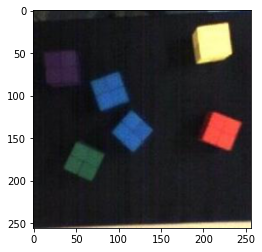

In [ ]:
test_img_idx = 142
img_path = '/content/drive/MyDrive/Speech2Pickup/train_img'
curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 1)

### Set speech input and Run the Result 
(sentence command in the open datatset)

In [ ]:
num_data_idx = random.choice(np.where(img_idx == test_img_idx)[0])
curr_speech = speech_inputs[num_data_idx, :, :]
curr_sentence = sentence[num_data_idx]

mean_of_esti, uncertainty = session_run(result_heatmap=result_heatmap,
                                        ph_image=ph_image,
                                        ph_speech=ph_speech,
                                        ph_dropout=ph_dropout,
                                        curr_test_img=curr_test_img,
                                        curr_speech=curr_speech,
                                        dropout_rate=dropout_rate,
                                        restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


### Set speech input and Run the Result 
(sentence command given by you)

https://stackoverflow.com/questions/54995034/is-it-possible-to-call-google-cloud-apis-from-google-colab

In [ ]:
import librosa
# from text_to_speech import text_to_speech_for_model_test
from process_data import return_mel_spec_single_channel

voice_config = {'accent': 'en-US',
                'gender': 'MALE'}
"""
Check https://cloud.google.com/text-to-speech/docs/voices for available voice configurations
'Speech2Pickup' supports only English
"""
# Fill in ##### with the command you like to give.
curr_sentence = '#####'
# text_to_speech_for_model_test(sentence=curr_sentence, voice_config=voice_config)
sampled_audio, sample_rate = librosa.load('/content/output.wav', sr=16000)

max_audio_len = 77520
n_fft = 2048
hop_length = int(n_fft/8)
win_length = int(n_fft/2)
if len(sampled_audio) > max_audio_len:
    raise ValueError('Too long audio length')
sampled_audio = np.append(sampled_audio, [0]*(max_audio_len-sampled_audio.shape[0]))

# Extract mel feature
curr_speech = return_mel_spec_single_channel(sampled_audio=sampled_audio,
                                             sample_rate=sample_rate,
                                             n_fft=n_fft,
                                             hop_length=hop_length,
                                             win_length=win_length,
                                             n_mels=n_mels,
                                             window='hann',
                                             log_scale=True)
curr_speech = curr_speech[np.newaxis, :, :]

# Get the model output
mean_of_esti, uncertainty = session_run(result_heatmap=result_heatmap,
                                        ph_image=ph_image,
                                        ph_speech=ph_speech,
                                        ph_dropout=ph_dropout,
                                        curr_test_img=curr_test_img,
                                        curr_speech=curr_speech,
                                        dropout_rate=dropout_rate,
                                        restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt')


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


### See the Result

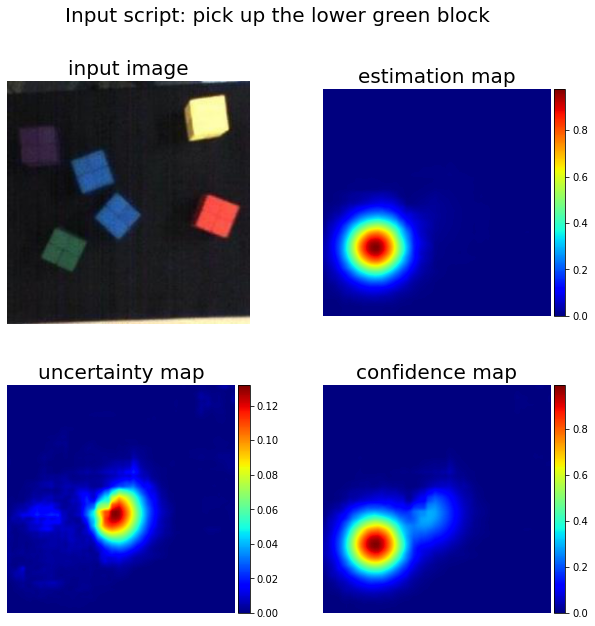

In [ ]:
import os
import matplotlib.pyplot as plt

if prev_img_idx != test_img_idx:
    num = 1
file_name = '/content/drive/MyDrive/Speech2Pickup/result/HGN_senEM/{}_{}'.format(test_img_idx, num)
utils.plot_HGN_result(curr_sentence, curr_test_img, mean_of_esti, uncertainty, save_state=False, save_path=file_name)
prev_img_idx = test_img_idx
num += 1

### Evaluate model : Model should be first defined

In [ ]:
# Restore model

restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


In [ ]:
# Evaluate model

import time

img_path = '/content/drive/MyDrive/Speech2Pickup/train_img'
dropout_rate = 0.1
num_test = len(idx_test)
num_correct = 0
correct_limit = 20 # 20 pixel (if the image size is 256x256)
error_idx = []
error = []
distances = []
taken_times = []

for idx in idx_test:
    test_img_idx = img_idx[idx, :]
    curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
    curr_speech = speech_inputs[idx, :, :]
    curr_pos_outputs = pos_outputs[idx, :]

    start = time.time()
    
    test_feed_dict = {ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                        ph_speech: np.tile(curr_speech, (T, 1, 1)),
                        ph_dropout: dropout_rate}
    test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

    test_heatmap = np.squeeze(test_heatmap)
    mean_of_esti = np.mean(test_heatmap, axis=0)
    
    mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)

    end = time.time()

    pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
    pose_esti = np.flip(pose_esti)
    
    distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
    if distance < correct_limit:
        num_correct += 1
    else:
        error_idx.append(idx)
        error.append(distance)
    
    taken_time = end - start
    taken_times.append(taken_time)
    distances.append(distance)

accuracy = (num_correct/num_test)*100
print('Speech2Pickup(senEM) accuracy: {}%'.format(accuracy))
    

Speech2Pickup(senEM) accuracy: 97.45762711864407%


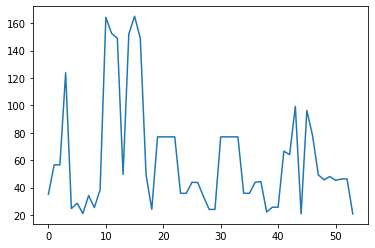

In [ ]:
# Plot error distance

import matplotlib.pyplot as plt

plt.plot(error)

In [ ]:
# Calculate time for preprocessing naive speech data

from process_data import return_mel_spec_single_channel
import time
import os

test_data = os.listdir('./drive/MyDrive/Speech2Pickup/test_speech_data')

preprocess_times = []
sr = 16000
max_audio_len = 77520
n_fft = 2048
hop_length = int(n_fft/8)
win_length = int(n_fft/2)

for data in test_data:
    full_file_path = os.path.join('./drive/MyDrive/Speech2Pickup/test_speech_data', data)

    sampled_audio, audio_sr = librosa.load(full_file_path, sr=sr)
    start = time.time()
    sampled_audio = np.append(sampled_audio, [0]*(max_audio_len-sampled_audio.shape[0]))
    _ = return_mel_spec_single_channel(sampled_audio, audio_sr, n_fft, hop_length, win_length, n_mels=40)
    end = time.time()
    inter_time = end - start
    preprocess_times.append(inter_time)

preprocess_times = np.asarray(preprocess_times)

In [ ]:
# Evaluate model inference time

taken_times_final = taken_times + preprocess_times

Q1 = np.percentile(taken_times_final, 25)
Q2 = np.percentile(taken_times_final, 50)
Q3 = np.percentile(taken_times_final, 75)
std = np.std(taken_times_final)
print('Q1: {}, Q2: {}, Q3: {}, std: {}'.format(Q1, Q2, Q3, std))

Q1: 0.32234305143356323, Q2: 0.32382941246032715, Q3: 0.325281023979187, std: 0.0024656367231998206


In [ ]:
# Evaluate model inference error (distance)

print('mean: {}, std: {}'.format(np.mean(distances), np.std(distances)))

mean: 6.263303112753747, std: 11.173530154521563


In [ ]:
# Evaluate model inference error (error)

print('mean: {}, std: {}'.format(np.mean(error), np.std(error)))

mean: 61.42559849046212, std: 40.14035004755675


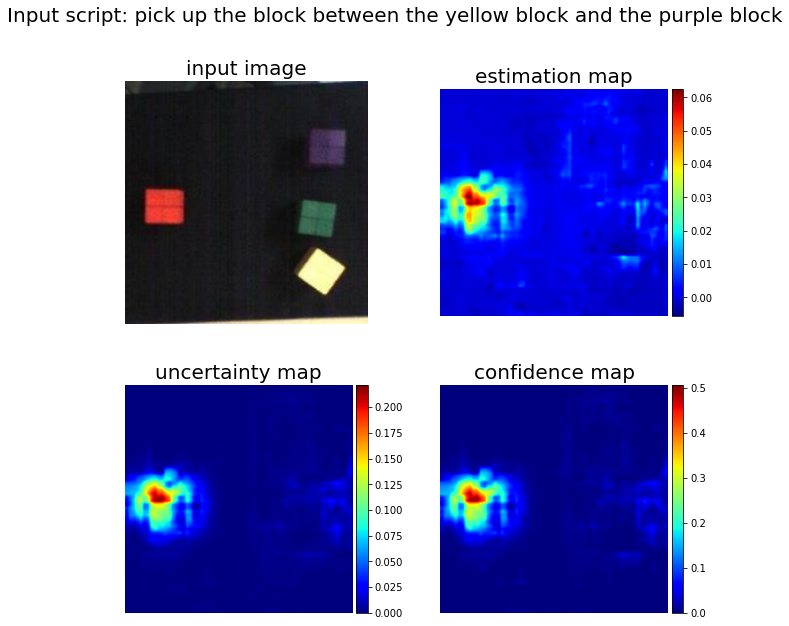

In [ ]:
# Plot one example of error case (maximum error)

idx = error_idx[np.argmax(error)]
test_img_idx = img_idx[idx, :]
curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
curr_speech = speech_inputs[idx, :, :]
curr_pos_outputs = pos_outputs[idx, :]
curr_sentence = sentence[idx]

test_feed_dict = {ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                    ph_speech: np.tile(curr_speech, (T, 1, 1)),
                    ph_dropout: dropout_rate}
test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

test_heatmap = np.squeeze(test_heatmap)
mean_of_esti = np.mean(test_heatmap, axis=0)
mean_of_squared_esti = np.mean(test_heatmap**2, axis=0)
squared_mean_of_esti = mean_of_esti ** 2
uncertainty = np.sqrt(mean_of_squared_esti - squared_mean_of_esti)
utils.plot_HGN_result(curr_sentence, curr_test_img, mean_of_esti, uncertainty, save_state=False, save_path='')

### Evaluate model with noise added test data : Model should be first defined

In [ ]:
# Download noise data

!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1vD81Qm6mCfekYr4YUk2YblzAMYpwJ8Ec' -O noise.wav
bg_path = './noise.wav'
bg, sr = librosa.load(bg_path, sr=16000)
n_fft = 2048
hop_length = int(n_fft/8)
win_length = int(n_fft/2)

bg_mel = return_mel_spec_single_channel(sampled_audio=bg,
                                                sample_rate=sr,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                win_length=win_length,
                                                n_mels=40,
                                                window='hann',
                                                log_scale=True)
bg_mel = bg_mel[np.newaxis, :, :]

In [ ]:
# Restore model

restore_path = '/content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto()
config.allow_soft_placement = True
config.gpu_options.allow_growth = True

T = 100

sess = tf.Session(config=config)
sess.run(init)
saver.restore(sess, restore_path)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Speech2Pickup/HGN_senEM_model/model.ckpt


In [ ]:
# Evaluate model

img_path = '/content/drive/MyDrive/Speech2Pickup/train_img'
dropout_rate = 0.1
num_test = len(idx_test)
num_correct = 0
correct_limit = 20 # 20 pixel (if the image size is 256x256)
error_idx = []
error = []
max_audio_len = 77520
n_fft = 2048
hop_length = int(n_fft/8)
win_length = int(n_fft/2)
count = 0

for idx in idx_test:
    count += 1
    print('Processing {}'.format(count))

    test_img_idx = img_idx[idx, :]
    curr_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 0)
    curr_speech = speech_inputs[idx, :, :]
    curr_pos_outputs = pos_outputs[idx, :]

    curr_speech = curr_speech + bg_mel[:, :, :303]
    
    test_feed_dict = {ph_image: np.tile(curr_test_img, (T, 1, 1, 1)),
                        ph_speech: np.tile(curr_speech, (T, 1, 1)),
                        ph_dropout: dropout_rate}
    test_heatmap = sess.run(result_heatmap, feed_dict=test_feed_dict)

    test_heatmap = np.squeeze(test_heatmap)
    mean_of_esti = np.mean(test_heatmap, axis=0)
    
    mean_of_esti = resize(mean_of_esti, [256, 256], preserve_range=True)
    pose_esti = np.unravel_index(np.argmax(mean_of_esti), mean_of_esti.shape)
    pose_esti = np.flip(pose_esti)
    
    distance = np.sqrt(np.sum((pose_esti - curr_pos_outputs)**2))
    if distance < correct_limit:
        num_correct += 1
    else:
        error_idx.append(idx)
        error.append(distance)

accuracy = (num_correct/num_test)*100
print('Speech2Pickup(senEM) accuracy: {}%'.format(accuracy))

Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12
Processing 13
Processing 14
Processing 15
Processing 16
Processing 17
Processing 18
Processing 19
Processing 20
Processing 21
Processing 22
Processing 23
Processing 24
Processing 25
Processing 26
Processing 27
Processing 28
Processing 29
Processing 30
Processing 31
Processing 32
Processing 33
Processing 34
Processing 35
Processing 36
Processing 37
Processing 38
Processing 39
Processing 40
Processing 41
Processing 42
Processing 43
Processing 44
Processing 45
Processing 46
Processing 47
Processing 48
Processing 49
Processing 50
Processing 51
Processing 52
Processing 53
Processing 54
Processing 55
Processing 56
Processing 57
Processing 58
Processing 59
Processing 60
Processing 61
Processing 62
Processing 63
Processing 64
Processing 65
Processing 66
Processing 67
Processing 68
Processing 69
Processing 70
Processing 71
Processing 72
P

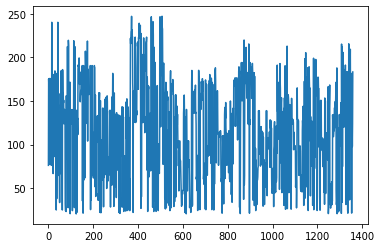

In [ ]:
# Plot error distance

import matplotlib.pyplot as plt

plt.plot(error)

### Conclusion:
### 1. The model is not robust to noise yet.
### 2. The training data span should be larger with couple of data augmentation techniques included (ex) noise, masking ..)
### 3. The training data should cover various sentence structure.
### 4. The encoder model should be trained with more general dataset (open dataset)